# Using enterprise to analyze PTA data

In this notebook you will learn:
* How to use `enterprise` to interact with PTA data,
* How to search in PTA data for GWs,
* How to perform Bayesian model selection,
* How to post-process your results.

If you are interested in working through this notebook, but do not want to install the software, we have prepared a related Google Colab notebook: https://colab.research.google.com/drive/1-ya9wNbDP1wEHN-SX1LWzUdITgtyc020?usp=sharing

By copying this notebook, you can install the software to your own Google Colab account and run the software without installation on your computer.

**Warning**: Sampling in this notebook is computationally intensive. It will take hours to sample properly. We have tried to cut it down somewhat while also leaving robust results that are indicative of what is actually done with a real analysis.

# Load modules

In [1]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Get par, tim, and noise files (this is not the preferred method when we have supplied pickled enterprise Pulsar files; see below)
Here we collect the tim and par files. 

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.

In [3]:
# some pathing to get to the data folder (this won't work if you change the parent folder name)
foldername = os.path.basename(os.getcwd())
if foldername != '12p5yr_stochastic_analysis':
    os.chdir(os.path.pardir)
datadir = os.path.join(os.getcwd(), 'data') # set your data directory
print(datadir)

/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data


In [4]:
# for the entire pta
parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), '*par')))
timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), '*tim')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

## Load into Pulsar class list

* The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.
* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.
* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

### Read par and tim files into enterprise Pulsar objects

In [5]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

* We can read-in some previously computed noise properties from single-pulsar analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 
* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.
* The noise properties have been stored as `json` files, and are read in to a big parameter dictionary.

In [6]:
## Get parameter noise dictionary
noise_ng12 = os.path.join(datadir, 'channelized_12p5yr_v3_full_noisedict.json')

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

# PTA Parameter Estimation

## Set up `enterprise` model for PTA upper-limit (*verbose version*)

* Usually, in a full PTA analysis we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`. 

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

* Another feature to notice is that **for upper limits** we do not use a uniform prior on the log of the red-noise or GWB amplitude. Instead we use a `LinearExp` prior (short for linear-exponent prior), that is a prior of the form $p(x)\propto 10^x$. This is how we can still use the log of the parameter to sample but place a uniform prior on the parameter itself. We do this for both the red noise and GWB amplitude parameters. **For detection analyses** we still use a `Uniform` prior on the log of the GWB amplitude. 

* In order to save on computing time we do not include spatial correlations here. Instead we model the GWB as a common red process across all pulsars. In `enterprise` we can do this with a simple trick. We pre-initialize the parameters before passing them to the `Signal` model. In this way the *same* parameter instance is used for all pulsars. Lastly, we fix the spectral index of the GWB to be 13/3 (4.33) using the `Constant` parameter.

* The requirement for a pulsar to be used in the NANOGrav dataset is that the pulsar has at least three years of data. For the sake of saving some time, we will increase that limit to 6 years (cutting the number of pulsars in half). This will give us a good idea of what the process looks like, while also reducing the computation time.

In [7]:
YR_SEC = 525600 * 60  # number of seconds in a year
YRS = 6  # number of years to cutoff the data at

# cut pulsars < X years:
new_psrs = []
for p in psrs:
    delta_t = p.toas.max() - p.toas.min()
    delta_t_yrs = delta_t / YR_SEC
    if delta_t_yrs > YRS:
        new_psrs.append(p)
        # print(p.name)
psrs = new_psrs
print(len(psrs), 'pulsars')

23 pulsars


In [8]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

In [9]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

### Parameters

In [10]:
# white noise parameters
efac = parameter.Constant() 
equad = parameter.Constant() 
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.LinearExp(-20, -11)
gamma = parameter.Uniform(0, 7)

# dm-variation parameters
log10_A_dm = parameter.LinearExp(-20, -11)
gamma_dm = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals

In [11]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan, name='gw')

# for spatial correltions you can do...
#orf = utils.hd_orf()
#crn = gp_signals.FourierBasisCommonGP(cpl, orf, components=30, Tspan=Tspan, name='gw')

# to add solar system ephemeris modeling...
bayesephem=False
if bayesephem:
    eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

# timing model
tm = gp_signals.TimingModel(use_svd=True)

In [12]:
# full model
if bayesephem:
    s = ef + eq + ec + rn + tm + eph + gw
else:
    s = ef + eq + ec + rn + tm + gw

In [13]:
# intialize PTA
models = []
        
for p in psrs:    
    models.append(s(p))
    
pta = signal_base.PTA(models)

In [14]:
print(len(pta.params))

47


### Set white noise parameters

In [15]:
pta.set_default_params(params)

INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_efac to 1.149036589204419
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_efac to 1.0543836580555548
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_efac to 1.080749375878354
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_efac to 1.2429537099744354
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_equad to -7.379759355541006
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_equad to -6.348065001180634
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_log10_equad to -6.51289896375955
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_log10_equad to -7.821737281350602
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_ecorr to -7.415374510054153
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_ecorr to -5.671108063699219
INFO: enterprise.signals.signal_base: S

### Set initial parameters drawn from prior

In [16]:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

### Set up sampler

In [17]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = os.path.join(os.getcwd(), 'chains_pta_test')

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=False)

### Sample!

This should take about 3.5 hours to sample. Note that a normal analysis would include from 1e6 to 5e6 samples. Here we would like it to finish a little faster, so we only look for 5e5 samples for about half the number of pulsars in the NANOGrav dataset. This should be enough to get an idea of what the posterior looks like.

In [19]:
# sampler for N steps
N = int(5e5)  # normally, we would use 5e6 samples (this will save time)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 2.00 percent in 242.351337 s Acceptance rate = 0.5898Adding DE jump with weight 50
Finished 99.80 percent in 8681.117901 s Acceptance rate = 0.273146
Run Complete


### Plot output

In [18]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])

In [19]:
ind = list(pta.param_names).index('log10_A_gw')

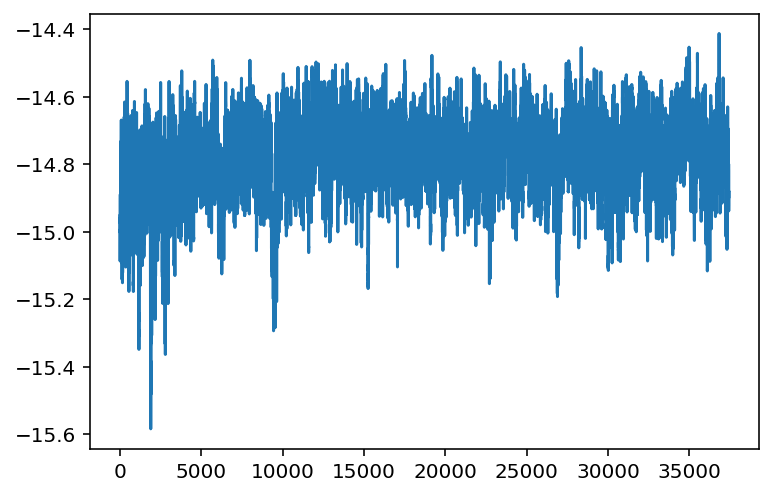

In [26]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

Text(0, 0.5, 'PDF')

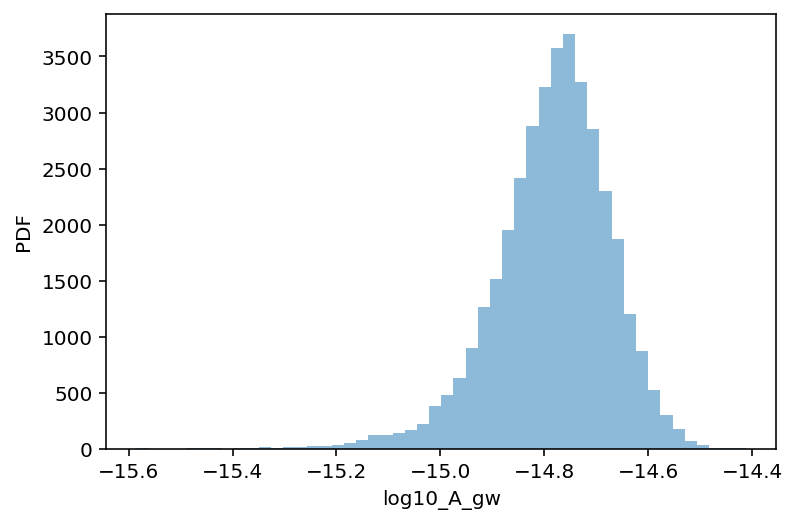

In [27]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')

## Discussion

* The posterior shows the amplitude of a common red noise process is supported by the data to be between about 1e-15.2 and 1e-14.5 with a spectral index of 4.33.

### Upper limit value

In [21]:
upper = 10**np.percentile(chain[burn:, -5], q=95)
print(upper)

2.391579658004618e-15


## Now, the easy way to do all of this...

Many of the steps above have been consolidated into convenient functions that do them all at once inside the `enterprise_extensions` package. In this section, we will show the process using these covenient functions.

In [22]:
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

In [35]:
psrlist = None  # define a list of pulsar name strings that can be used to filter.
# some pathing to get to the data folder (this won't work if you change the parent folder name)
foldername = os.path.basename(os.getcwd())
if foldername != '12p5yr_stochastic_analysis':
    os.chdir(os.path.pardir)
datadir = os.path.join(os.getcwd(), 'data') # set your data directory
print(datadir)

/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data


In [36]:
# for the entire pta
parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), '*par')))
timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), '*tim')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile...
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [48]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

In [49]:
YR_SEC = 525600 * 60  # number of seconds in a year
YRS = 6  # number of years to cutoff the data at

# cut pulsars < X years:
new_psrs = []
for p in psrs:
    delta_t = p.toas.max() - p.toas.min()
    delta_t_yrs = delta_t / YR_SEC
    if delta_t_yrs > YRS:
        new_psrs.append(p)
        # print(p.name)
psrs = new_psrs
print(len(psrs), 'pulsars')

23 pulsars


In [50]:
## Get parameter noise dictionary
noise_ng12 = os.path.join(datadir, 'channelized_12p5yr_v3_full_noisedict.json')

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

In [ ]:
pta = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                           red_components=30, common_components=30, 
                           white_vary=False, noisedict=params, tm_svd=True, 
                           gamma_common=4.33, upper_limit_red=True, 
                           upper_limit_common=False, bayesephem=False)

In [ ]:
# Setup an instance of a HyperModel.
# This doesn't mean we are doing model selection (yet!), but the 
# hypermodel module gives access to some nifty sampling schemes.
super_model = hypermodel.HyperModel({0: pta})

In [ ]:
outDir = os.path.join(os.getcwd(), 'chains_pta_test')
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=False)

In [ ]:
# sampler for N steps
N = int(1e6)
x0 = super_model.initial_sample()

In [ ]:
# sample
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [ ]:
# Read in chains and parameters

chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [ ]:
# Plot GW amplitude posterior
ind = list(pars).index('gw_log10_A')
plt.hist(chain[burn:,ind], bins=40);

In [ ]:
# Compute upper limit
print(model_utils.ul(chain[burn:, ind], q=95.0))

* Now that we're done with a basic analysis for the GWB, let's move on to model selection

# PTA Model Selection

We want to be able to compute the Bayesian odds for a GWB in the data. This can be done using the hypermodel class, where we choose between a model with a common (but uncorrelated) red process in the pulsars, and a GWB affecting all pulsars.

We typically perform detection-type analyses with uniform-in-log priors on all amplitude parameters for low-frequency processes. This is implemented below whenever we switch `upper_limit` to be equal to `False`.

## Setup dictionary of PTA models

## **Warning**

* Running the hypermodel for the pulsar set used above will take several hours

In [51]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                           red_components=30, common_components=30, 
                           white_vary=False, noisedict=params, tm_svd=True, 
                           gamma_common=4.33, upper_limit_red=False, 
                           upper_limit_common=False, bayesephem=False, orf=None)
pta[1] = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                           red_components=30, common_components=30, 
                           white_vary=False, noisedict=params, tm_svd=True, 
                           gamma_common=4.33, upper_limit_red=False, 
                           upper_limit_common=False, bayesephem=False, orf='hd')

INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_efac to 1.149036589204419
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_efac to 1.0543836580555548
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_efac to 1.080749375878354
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_efac to 1.2429537099744354
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_equad to -7.379759355541006
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_equad to -6.348065001180634
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_log10_equad to -6.51289896375955
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_log10_equad to -7.821737281350602
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_ecorr to -7.415374510054153
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_ecorr to -5.671108063699219
INFO: enterprise.signals.signal_base: S

In [52]:
super_model = hypermodel.HyperModel(pta)

## Sample

In [53]:
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding nmodel uniform distribution draws...



In [54]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [46]:
# sample
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 0.20 percent in 26.339144 s Acceptance rate = 0.5242Adding DE jump with weight 50
Finished 16.60 percent in 2390.718504 s Acceptance rate = 0.481364

KeyboardInterrupt: 

## Post-process

In [ ]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [ ]:
print(pars)

In [ ]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('gw_log10_A')

# ORF = None
#plt.hist(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], bins=40);

# ORF = Hellings & Downs
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=40);

In [ ]:
# Plot histogram for GWB model selection
plt.hist(chain_burn[:, ind_model], bins=40);

## Bayes factors

### Savage-Dickey Bayes factor

This gives the signal-vs-noise Bayes factor for a common red process in the pulsars plus intrisnc noise, versus intrinsic noise alone.

In [ ]:
print(model_utils.bayes_fac(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], ntol=1))

### Posterior odds ratio

This gives the Bayesian odds between a model with a Hellings & Downs correlated red process between pulsars, and a common (but uncorrelated) red process between pulsars. This is the smoking-gun detection statsitic for a GWB signal.

In [ ]:
print(model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1]))